In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 1. Data Generation

In [134]:
def get_toy_data(batch_size, labels, centers):
    if len(CENTERS) != len(LABELS):
        print("Error: LEN(centers) is not equal to LEN(labels)")
    else:
        x_data = []
        y_targets = np.zeros(batch_size)
        n_centers = len(CENTERS)
        
        for batch_i in range(batch_size):
            ### Randomly select one combination from n center-label combinations.
            center_idx = np.random.randint(0, n_centers)
            ### Add one sample to x_data
            x_data.append(np.random.normal(loc=CENTERS[center_idx]))
            ### Add one sample to y_data
            y_targets[batch_i] = LABELS[center_idx]
        return torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_targets, dtype=torch.int64)
    
def visualize_results_without_hyperplane(x_data,y_data,title):
    """
    Args:
        x_data (torch.Tensor): an input data tensor.
        y_data (torch.Tensor): an target data tensor.
    """
    ##### Specify colors and markers
    ### colors = [the face color for y=0 points, the face color for y=1 points]
    face_colors    = ['yellow','yellow']
    edge_color     = 'black'
    ### markers = [the marker for y=0 points, the markerfor y=1 points]
    markers        = ['o', 'X']
    
    
    x_data = x_data.numpy()
    y_data = y_data.numpy().astype(np.int32)
    
    n_classes      = len(np.unique(y_data))
    
    ##### all_x[i] stores the x coorinates of y=i observations (i=0,1)
    # [array([[ , ],[ , ], ... ,[ , ]]),array([[ , ],[ , ], ... ,[ , ]])]
    all_x          = [[] for _ in range(n_classes)]
    
    ##### all_facecolors[i] stores the face color from face_colors list, for y=i observations (i=0,1)
    # [['white','white',...,'white'],['white','white',...,'white']]
    all_facecolors = [[] for _ in range(n_classes)]
    
    
    for x_i, y_i in zip(x_data, y_data):
        all_x[y_i].append(x_i)
        all_facecolors[y_i].append(face_colors[y_i])
        
    all_x = [np.stack(x_list) for x_list in all_x]
    
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
    
    for x_list,facecolor_list,marker,i in zip(all_x, all_facecolors, markers,[0,1]):
        ax.scatter(x_list[:, 0],
                   x_list[:, 1], 
                   edgecolor=edge_color, 
                   marker=marker, 
                   facecolor=facecolor_list, s=100,label='y='+str(i))
    plt.title(title)
    plt.legend()
    plt.show()

### Example 1
### $X$ is a two-dimension random variable following a mixtured (bi-variate) Normal distribution.
- ### Case 1 (p=50%): $X_1 \sim N(3,1)$, $X_2 \sim N(3,1)$, $Y=0$
- ### Case 2 (p=50%): $X_1 \sim N(3,1)$, $X_2 \sim N(-3,1)$, $Y=1$


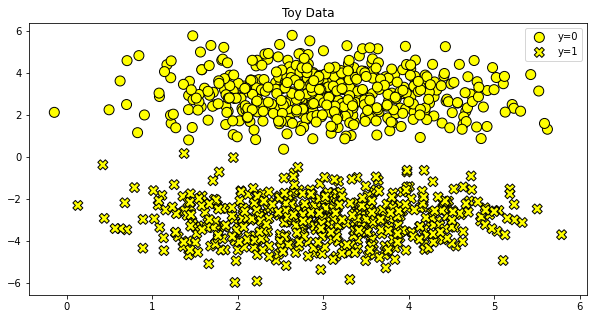

In [135]:
LABELS  = [0,1]
CENTERS = [(3,3),(3,-3)]
x_data, y_data = get_toy_data(batch_size=1000,labels = LABELS,centers = CENTERS)
visualize_results_without_hyperplane(x_data, y_data,'Toy Data')

### Example 2
### $X$ is a two-dimension random variable following a mixtured (bi-variate) Normal distribution.
- ### Case 1 (p=25%): $X_1 \sim N(-3,1)$, $X_2 \sim N(-3,1)$, $Y=0$
- ### Case 2 (p=25%): $X_1 \sim N(-3,1)$, $X_2 \sim N(3,1)$, $Y=1$
- ### Case 3 (p=25%): $X_1 \sim N(3,1)$, $X_2 \sim N(-3,1)$, $Y=1$
- ### Case 4 (p=25%): $X_1 \sim N(3,1)$, $X_2 \sim N(3,1)$, $Y=0$

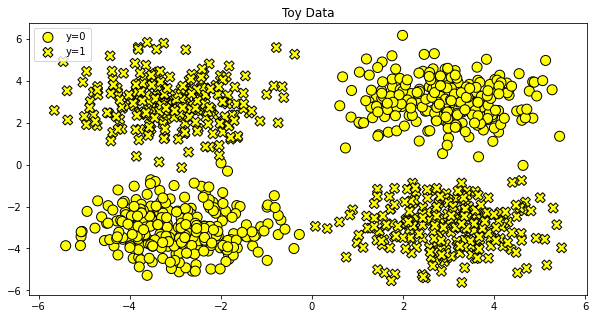

In [137]:
LABELS = [0, 1, 1, 0]
CENTERS = [(-3, -3), (-3, 3), (3, -3), (3, 3)]
x_data, y_data = get_toy_data(batch_size=1000,labels = LABELS,centers = CENTERS)
visualize_results_without_hyperplane(x_data, y_data,'Toy Data')

# 2. Define the Modeling Components 
## 2.1 Classifier
### [More details about the codes](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Perceptron_ToyData/perceptron_classifiers.ipynb)

## Perceptron - A single layer perceptron classifier

In [14]:
class Perceptron(nn.Module):
    """ A Perceptron is one Linear layer """
    def __init__(self, input_dim):
        """
        Args:
            input_dim (int): size of the input features
        """
        ### super() invokes the constructor of the parent class nn.Module for the Perceptron class.
        ### .__init__() calls the constructor of the parent class, executing the initialization 
        ### operations of the parent class. 
        super(Perceptron, self).__init__()
        
        ### creates a linear layer (nn.Linear)
        ### "input_dim" represents the number of input features
        ### "1" indicates the number of output features for the linear layer
        self.fc1 = nn.Linear(input_dim, 1)

    def forward(self, x_in):
        """The forward pass of the MLP
        Args:
            x_in (torch.Tensor): an input data tensor.
            x_in.shape should be (batch, input_dim)
        Returns:
            the resulting tensor. tensor.shape should be (batch, 1)
        """
        return torch.sigmoid(self.fc1(x_in))

## MultilayerPerceptron - A multilayer percerptron
### * Note that a perceptron classifier is a special case of a multilayer perceptron classifier. The following two classifiers are equivalent and can both be used for binary classification:
### - Perceptron(input_dim=2)
### - MultilayerPerceptron(input_size=2, hidden_size=anything, num_hidden_layers=0, output_size=2)

In [15]:
class MultilayerPerceptron(nn.Module):
    """ A multilayer perceptron network """
    
    def __init__(self, input_size, hidden_size, output_size, 
                 num_hidden_layers, hidden_activation=nn.Sigmoid):
        """
        Args:
            input_size (int): size of the input 
            hidden_size (int): size of the hidden layers
            output_size (int): size of the output
            num_hidden_layers (int): number of hidden layers
            hidden_activation (torch.nn.*): the activation class
        """
        super(MultilayerPerceptron, self).__init__()
        self.module_list = nn.ModuleList()
        
        interim_input_size = input_size
        interim_output_size = hidden_size
        
        for _ in range(num_hidden_layers):
            self.module_list.append(nn.Linear(interim_input_size, interim_output_size))
            self.module_list.append(hidden_activation())
            interim_input_size = interim_output_size
            
        self.fc_final = nn.Linear(interim_input_size, output_size)
        
        self.last_forward_cache = []
       
    def forward(self, x, apply_softmax=False):
        """The forward pass of the MLP
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        self.last_forward_cache = []
        self.last_forward_cache.append(x.to("cpu").numpy())

        for module in self.module_list:
            x = module(x)
            self.last_forward_cache.append(x.to("cpu").data.numpy())
            
        output = self.fc_final(x)
        self.last_forward_cache.append(output.to("cpu").data.numpy())

        if apply_softmax:
            output = F.softmax(output, dim=1)
            
        return output

### Examples

In [104]:
x_data, y_data  = get_toy_data(batch_size=10, labels = LABELS, centers = CENTERS)

In [105]:
classifier1 = Perceptron(2)
print('Outputs of Perceptron classifier - a one-dimension probability vector')
print(classifier1(x_data))

Outputs of Perceptron classifier - a one-dimension probability vector
tensor([[0.1559],
        [0.5073],
        [0.5968],
        [0.5947],
        [0.5946],
        [0.3959],
        [0.3707],
        [0.3894],
        [0.4079],
        [0.5383]], grad_fn=<SigmoidBackward0>)


In [106]:
classifier2 = MultilayerPerceptron(input_size=2, hidden_size=999, num_hidden_layers=0, output_size=2)
print('Outputs of MultilayerPerceptron classifier - a two-dimension logit vector')
print(classifier2(x_data))

Outputs of MultilayerPerceptron classifier - a two-dimension logit vector
tensor([[ 1.2836, -0.5680],
        [ 3.5554,  1.1702],
        [ 0.8885, -0.0219],
        [ 0.1784, -0.3768],
        [ 0.1600, -0.3862],
        [-1.6156, -1.5532],
        [ 3.0454,  0.7185],
        [-0.0611, -0.7927],
        [-1.7811, -1.6174],
        [ 2.3022,  0.5935]], grad_fn=<AddmmBackward0>)


## 2.2 The Loss Function (Binary Cross-Entropy)
### - The loss - "how far off" the model predictions are from the target.
### - The gradient of the loss function - a signal for “how much” the parameters should change (according to "how much" each parameter contributed to the loss function).

In [16]:
bce_loss       = nn.BCELoss()
cross_ent_loss = nn.CrossEntropyLoss()

## 2.3 The Optimizer
### - Iteratively updating each parameter with the gradient of the loss function with respect to that parameter.
### - Implements Adam algorithm [optim.Adam()](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)

In [17]:
perceptron = Perceptron(input_dim=2)

### lr: learning rate (default: 1e-3)
optimizer = optim.Adam(params=perceptron.parameters(),
                       lr=0.001)        ## This is an example
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

# 3. Visualizing Results

## 3.1 With decision bountary / without hyperplane
### See Section 1.

## 3.2 With decision bountary / hyperplane
### See [here](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Perceptron_ToyData/perceptron_visualization.ipynb) for more details about plotting the hyperplain using contour lines.

In [177]:
def visualize_results_with_hyperplane(model, model_type, x_data, y_data, title=''):
    """
    Args:
        x_data (torch.Tensor): an input data tensor.
        y_data (torch.Tensor): an target data tensor.
    """    
    
    if model_type == 'perceptron':
        ### If using the perceptron model, the model predictions are probabilities.
        ### Using 0.5 as the threshold. 
        
        y_pred    = model(x_data)
        y_pred    = (y_pred>0.5).to(torch.int64).squeeze().numpy().astype(np.int32)
    elif model_type == 'mlp':
        _,y_pred  = model(x_data,apply_softmax=True).max(dim=1)
        y_pred    = y_pred.numpy()

        
    x_data    = x_data.numpy()
    y_data    = y_data.numpy().astype(np.int32)
    
    n_classes = 2

    all_x          = [[] for _ in range(n_classes)]
    all_facecolors = [[] for _ in range(n_classes)]

    ##### Specify colors and markers
    ### colors = [the face color for correctly predicted points, 
    ###           the face color for incorrectly predicted points]
    face_colors    = ['green','orange']
    edge_color     = 'black'
    ### markers = [the marker for y=0 points, the markerfor y=1 points]
    markers        = ['o', 'X']
    
    ##### List "all_x[i]": the x coorinates of y=i observations (i=0,1)
    ##### List "all_facecolors[i]": the face color(from face_colors defined above) 
    #####                           for y=i observations (i=0,1)

    for x_i, y_pred_i, y_i in zip(x_data,y_pred,y_data):
        all_x[y_i].append(x_i)
        if y_pred_i == y_i:
            all_facecolors[y_i].append(face_colors[0])
        else: 
            all_facecolors[y_i].append(face_colors[1])

    all_x = [np.stack(x_list) for x_list in all_x]
    
    ### ranges of x1 and x2
    x_1_lim = (min([x_list[:,0].min() for x_list in all_x]), max([x_list[:,0].max() for x_list in all_x]))
    x_2_lim = (min([x_list[:,1].min() for x_list in all_x]), max([x_list[:,1].max() for x_list in all_x]))

    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3))
    margin=0.5
    ax.set_xlim(x_1_lim[0]-margin,x_1_lim[1]+margin)
    ax.set_ylim(x_2_lim[0]-margin,x_2_lim[1]+margin)

    for x_list,facecolor_list,marker in zip(all_x, all_facecolors, markers):
        ax.scatter(x_list[:,0],
                   x_list[:,1], 
                   edgecolor = edge_color, 
                   marker    = marker, 
                   facecolor = facecolor_list, s=100)

    xx1 = np.linspace(x_1_lim[0], x_1_lim[1], 30)
    xx2 = np.linspace(x_2_lim[0], x_2_lim[1], 30)
    XX2, XX1 = np.meshgrid(xx2, xx1)
    x1x2 = np.vstack([XX1.ravel(), XX2.ravel()]).T
    
    if model_type == 'perceptron':
        Z = model(torch.tensor(x1x2, dtype=torch.float32)).detach().numpy().reshape(XX1.shape)
        ax.contour(XX1, XX2, Z, colors='k', levels=[0.5], linestyles=['-'])
    elif model_type == 'mlp':
        for i in range(n_classes):
            Z = model(torch.tensor(x1x2, dtype=torch.float32),apply_softmax=True)
            Z = Z[:,i].data.numpy().reshape(XX1.shape)
            ax.contour(XX1, XX2, Z, colors='k', levels=[0.46], linestyles=['-'])
    
    plt.title(title)
    plt.show()


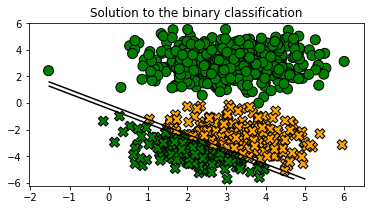

In [178]:
### with no hidden layer - a single perceptron
mlp_0hl = MultilayerPerceptron(input_size=2, hidden_size=999,
                               num_hidden_layers=0, output_size=2)
x_data, y_data = get_toy_data(batch_size=1000, labels = LABELS, centers = CENTERS)
visualize_results_with_hyperplane(mlp_0hl,'mlp',
                                  x_data, y_data,
                                  'Solution to the binary classification')

/var/folders/6s/wxmy299j1592tl76rwp6kg3h0000gn/T/ipykernel_2995/3751206151.py:76: UserWarning: No contour levels were found within the data range.
  ax.contour(XX1, XX2, Z, colors='k', levels=[0.46], linestyles=['-'])


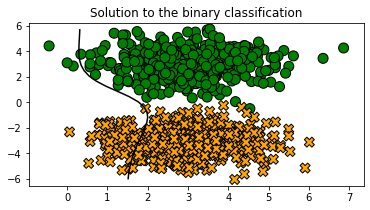

In [179]:
### with 1 hidden layer - 
mlp_1hl = MultilayerPerceptron(input_size=2, hidden_size=3,
                               num_hidden_layers=1, output_size=2)
x_data, y_data = get_toy_data(batch_size=1000, labels = LABELS, centers = CENTERS)
visualize_results_with_hyperplane(mlp_1hl,'mlp',
                                  x_data, y_data,
                                  'Solution to the binary classification')

/var/folders/6s/wxmy299j1592tl76rwp6kg3h0000gn/T/ipykernel_2995/3751206151.py:76: UserWarning: No contour levels were found within the data range.
  ax.contour(XX1, XX2, Z, colors='k', levels=[0.46], linestyles=['-'])


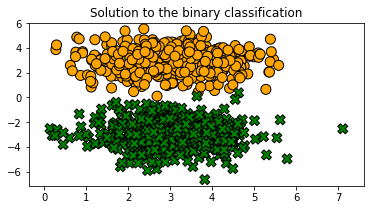

In [180]:
### with 2 hidden layer
mlp_2hl = MultilayerPerceptron(input_size=2, hidden_size=3,
                               num_hidden_layers=2, output_size=2)
x_data, y_data = get_toy_data(batch_size=1000, labels = LABELS, centers = CENTERS)
visualize_results_with_hyperplane(mlp_2hl,'mlp',
                                  x_data, y_data,
                                  'Solution to the binary classification')

# 4. Training A Classifier
## 4.1 Steps in a gradient-stepping algorithm
### 1) Resets the gradients currently stored inside the model, using function [zero_grad()](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html).
### 2) Computes outputs (y_pred) given the input data (x_data). 
### 3) Computes loss (y_pred) given the model outputs (y_pred) and the targets.
### 4) Iteratively propagates the loss backward through the computational graph and notifies each parameter of its gradient, using function [backward()](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html).
### 5) The optimizer instructs the parameters how to update their values knowing the gradient, using function [step()](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html).
### 6) The training data is partitioned into batches. Each iteration of the gradient step (Step 1-5) is performed on a batch of data. After a number of batches, the training loop has completed an epoch. The batch size, number of batches per epoch, and number of epochs are hyperparameters. There are two nested loops in this supervised training:
### - Inner loop: over a number of batches
### - Outer loop: repeats the innter loop over a fixed number of epoches
### 7) Stop the training loop if the  stopping (termination) criteria is met


## 4.2 Helper Functions

In [138]:
def early_termination(loss_change, change_threshold, epoch, max_epochs):
    ### Return True or False for early termination
    ### Two optional criterion: 
    ### 1) the loss change < change_threshold (batch-level loss)
    ### 2) the current training has already exceeded max_epochs epochs
    
    terminate_for_loss_change = loss_change < change_threshold
    terminate_for_epochs      = epoch > max_epochs
    
    #terminate_final           = terminate_for_loss_change
    #terminate_final           = terminate_for_epochs
    #terminate_final = terminate_for_loss_change or terminate_for_epochs
    terminate_final = terminate_for_loss_change and terminate_for_epochs
    
    return terminate_final

In [189]:
### linearly-separable
LABELS  = [0,1]
CENTERS = [(3,3),(3,-3)]


In [190]:

### Not linearly-separable
#LABELS = [0, 1, 1, 0]
#CENTERS = [(-3, -3), (-3, 3), (3, -3), (3, 3)]

In [211]:
np.random.seed(123)
x_data_static, y_truth_static = get_toy_data(batch_size=1000, labels = LABELS, centers = CENTERS)

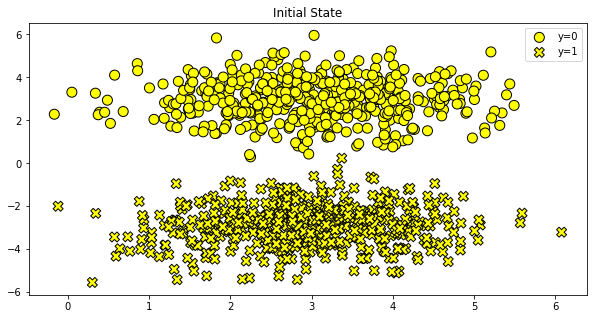

In [212]:
visualize_results_without_hyperplane(x_data_static, y_truth_static,'Initial State')

In [213]:
### Single Layer Perceptron
input_size        = 2
hidden_size       = 123   # won't use this when num_hidden_layer=0, but still set it
num_hidden_layers = 0
output_size       = 2

mlp_h0 = MultilayerPerceptron(input_size=input_size, 
                              hidden_size=hidden_size,
                              num_hidden_layers=num_hidden_layers,
                              output_size=output_size)

In [214]:
losses      = []
batch_size  = 10000
n_batches   = 10
max_epochs  = 5

loss_change = 1.0
last_loss   = 10.0
change_threshold = 1e-2
epoch = 0

In [215]:
classifier = mlp_h0

In [216]:
lr = 0.01
optimizer = optim.Adam(params=classifier.parameters(), lr=lr)
cross_ent_loss = nn.CrossEntropyLoss()


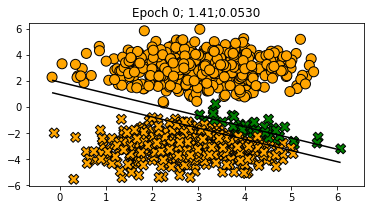

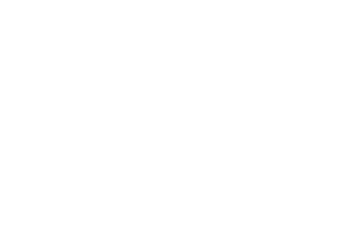

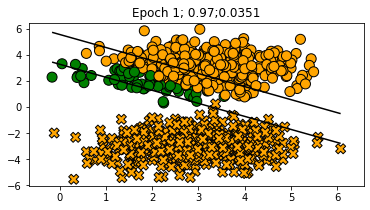

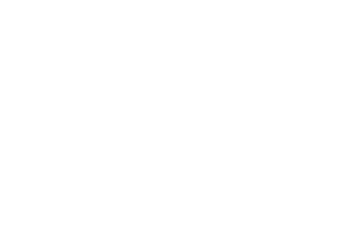

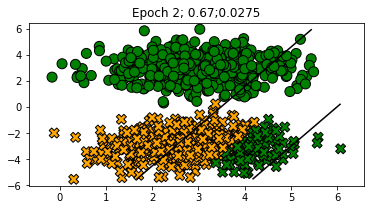

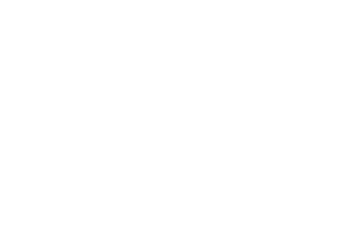

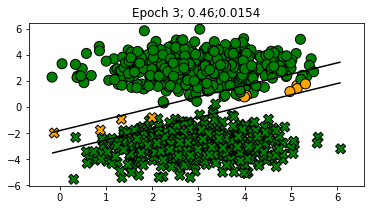

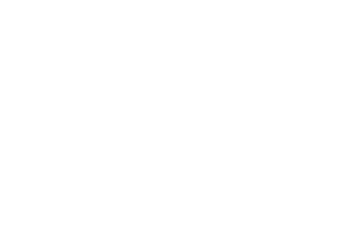

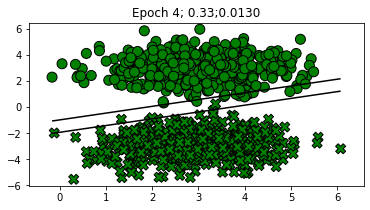

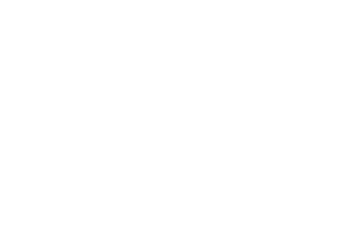

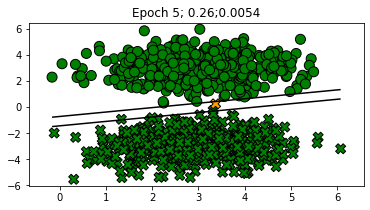

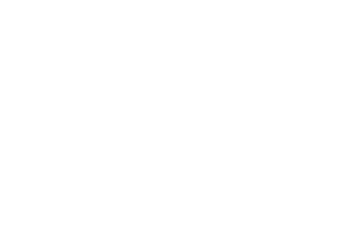

In [217]:
while not early_termination(loss_change, change_threshold, epoch, max_epochs):
    for _ in range(n_batches):
        # step 0: get a new training data
        x_data, y_target = get_toy_data(batch_size,labels = LABELS, centers = CENTERS)
 
        # step 1: zero the gradients
        classifier.zero_grad()
        
        # step 2: run the forward pass
        y_pred = classifier(x_data).squeeze()
        
        # step 3: compute the loss
        loss = cross_ent_loss(y_pred, y_target.long())

        # step 4: compute the backward pass
        loss.backward()
        
        # step 5: have the optimizer take an optimization step
        optimizer.step()
        
        # auxillary: bookkeeping
        loss_value = loss.item()
        losses.append(loss_value)
        loss_change = abs(last_loss - loss_value)
        last_loss = loss_value
    
    visualize_results_with_hyperplane(classifier,
                                      'mlp',
                                      x_data_static, 
                                      y_truth_static,
                                      title=f"Epoch {epoch}; {loss_value:0.2f};{loss_change:0.4f}")
   
    plt.axis('off')
    epoch += 1
